# FOV Bscope2

The script below will load images of a calibration grid and use these to calculate the field of view size and pixel size of the two-photon microscope. The images were made using a grid-coverslide (Thorlabs, Grid Distortion Target, 3" x 1", 10, 50, 100, and 500 µm Grid Spacings, article number R1L3S3P). By having a fluorescent dye in the immersion medium, the grid will become visible when focusing the image plane a few micron below the surface of the coverslip.

---
### Imports
First import the modules

In [1]:
import os, glob
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.io import imread

---
### Load the data
Define data location and meta data in a list with dictionaries

In [2]:
datapath = "./data"
filebase = "AVG_20180131_GRID_"
metadata = [{"fileno": 1, "zoom": 1.0, "grid": 50},
            {"fileno": 2, "zoom": 1.5, "grid": 50},
            {"fileno": 3, "zoom": 2.0, "grid": 50},
            {"fileno": 4, "zoom": 3.0, "grid": 50},
            {"fileno": 5, "zoom": 4.0, "grid": 50},
            {"fileno": 6, "zoom": 5.0, "grid": 50},
            {"fileno": 7, "zoom": 6.0, "grid": 10}]

And let's load the tiffs with the different FOV's

In [3]:
images = []
nimages = len(metadata)
print("Loading {} images".format(nimages))
for nr,meta in enumerate(metadata):
    filename = os.path.join( datapath, filebase+str(meta["fileno"]).zfill(3)+".tif")
    print("{}) {}, zoom={}, grid={}".format(nr,filename,meta["zoom"],meta["grid"]))
    images.append( np.float64(imread(filename)) )

Loading 7 images
0) ./data/AVG_20180131_GRID_001.tif, zoom=1.0, grid=50
1) ./data/AVG_20180131_GRID_002.tif, zoom=1.5, grid=50
2) ./data/AVG_20180131_GRID_003.tif, zoom=2.0, grid=50
3) ./data/AVG_20180131_GRID_004.tif, zoom=3.0, grid=50
4) ./data/AVG_20180131_GRID_005.tif, zoom=4.0, grid=50
5) ./data/AVG_20180131_GRID_006.tif, zoom=5.0, grid=50
6) ./data/AVG_20180131_GRID_007.tif, zoom=6.0, grid=10


Let's visualize the grids below, as a check

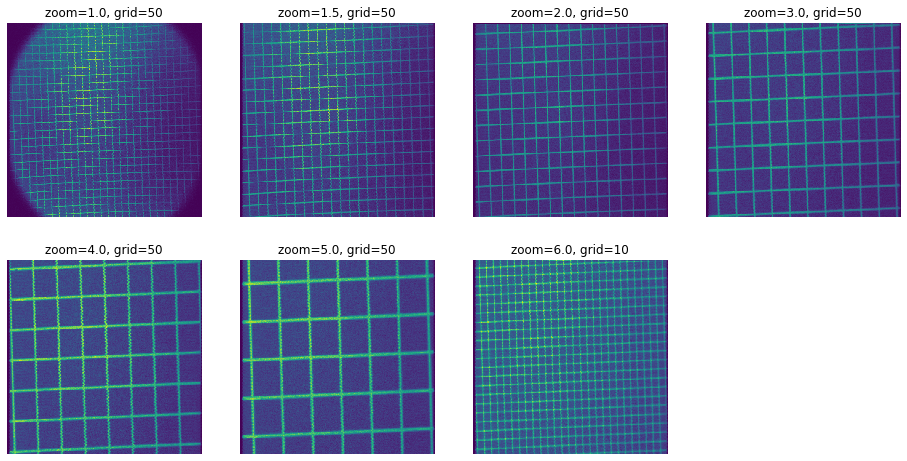

In [4]:
plt.figure(figsize=(16,int(np.ceil(nimages/4))*4), facecolor='w', edgecolor='w')
for nr,im in enumerate(images):
    ax = plt.subplot2grid( (int(np.ceil(nimages/4)),4), (int(np.floor(nr/4)),int(np.mod(nr,4))) )
    plt.imshow(im)
    plt.title("zoom={}, grid={}".format(metadata[nr]["zoom"],metadata[nr]["grid"]))
    plt.axis("off")
plt.show()

---
### Calculate grid spacing
The function below calculates the spacing between the grid lines along the first axis (axis 0, vertical).

In [5]:
def get_grid_spacing( im, slice_range=100, sliding_window=140, exclude_edge=30, threshold_ratio=0.4 ):
    """
    This function calculates the distance between grid lines in an image. It does not 
    require the grid to be aligned perfectly parallel to the image axes.
    Inputs
    - im: A 2D numpy array containing the image with the grid lines.
    - slice_range: Thickness of the slice of data to be analyzed
    - sliding_window: Size of the sliding window for correcting non-uniform brightness
    - exclude_edge: Exclude this many pixels from the edge
    Returns
    - 
    """
    # Get the mean fluorescence from a vertical slice in the center of the image
    ylen,xlen = im.shape
    full_slice = np.mean( 
        im[:,int(np.round(xlen/2)-(slice_range/2)):int(np.round(xlen/2)+(slice_range/2))], axis=1 )
    plt.plot(full_slice,'g')
    
    # Exclude data at the edges
    xcoords = np.arange(ylen)
    crop_slice = full_slice[exclude_edge:ylen-exclude_edge]
    xcoords = xcoords[exclude_edge:ylen-exclude_edge]
    ylen = len(crop_slice)
    
    # Find a threshold for the peaks, corrected for non-uniform image brightness
    sl_min = np.zeros_like(crop_slice)
    sl_max = np.zeros_like(crop_slice)
    for y in range(ylen):
        range_min = int(np.max((0,y-(sliding_window/2))))
        range_max = int(np.min((ylen-1,y+(sliding_window/2))))
        sl_min[y] = np.min(crop_slice[range_min:range_max])
        sl_max[y] = np.max(crop_slice[range_min:range_max])
    sl_thresh = sl_min + (threshold_ratio*(sl_max-sl_min))
    plt.plot(xcoords,sl_min,'k')
    plt.plot(xcoords,sl_max,'k')
    plt.plot(xcoords,sl_thresh,'r')
    
    # Find and display peaks, but remove if the peak if the first frame because it might be inaccurate
    peaks = np.argwhere( np.diff( (crop_slice>sl_thresh)*1.0 ) == 1 )
    if peaks[0] == 0:
        peaks = peaks[1:]
    for y in peaks.ravel():
        plt.plot(xcoords[y],sl_thresh[y],color='black', marker='o', markersize=4)
    
    # Now, calculate the mean distance in pixels between the peaks and return the value
    grid_spacing = np.mean((peaks[1:]-peaks[:-1]))
    plt.text(ylen/2, np.min(full_slice), "spacing={}".format(np.round(grid_spacing,1)), 
         horizontalalignment='center', verticalalignment='center')
    return grid_spacing

Below we run the function on each calibration image. The function calculates the grid spacing along the 1st axis, the vertical axis, therefore we transpose the input image so that we get the spacing along the x-axis

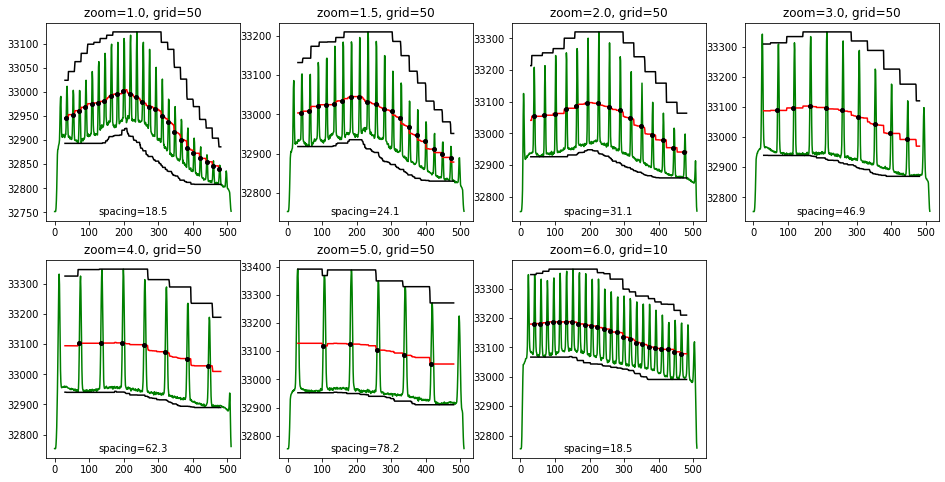

In [6]:
x_grid_spacing_px = np.zeros((nimages))
plt.figure(figsize=(16,int(np.ceil(nimages/4))*4), facecolor='w', edgecolor='w')
for nr,im in enumerate(images):
    ax = plt.subplot2grid( (int(np.ceil(nimages/4)),4), (int(np.floor(nr/4)),int(np.mod(nr,4))) )
    x_grid_spacing_px[nr] = get_grid_spacing( im.T )
    plt.title("zoom={}, grid={}".format(metadata[nr]["zoom"],metadata[nr]["grid"]))
plt.show()

We also run the function to get the spacing along the y-axis. Inspect each plot, to make sure the thresholds are set correctly.

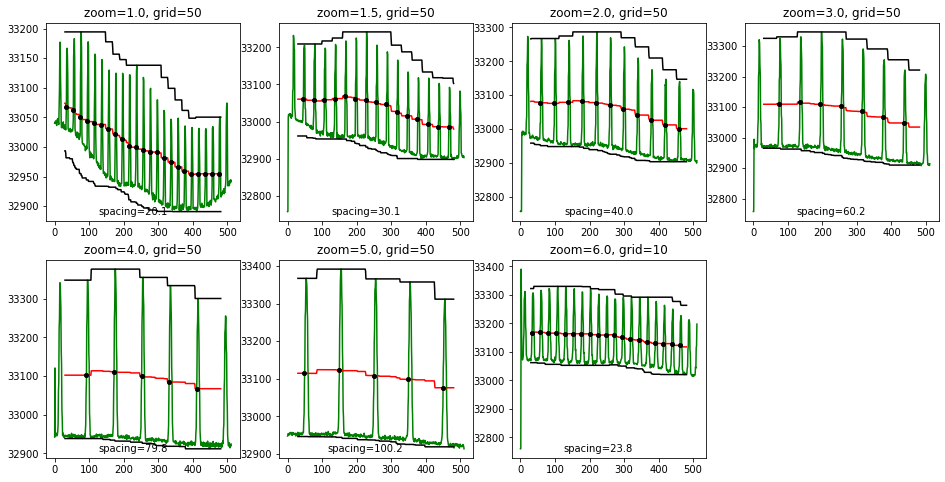

In [7]:
y_grid_spacing_px = np.zeros((nimages))
plt.figure(figsize=(16,int(np.ceil(nimages/4))*4), facecolor='w', edgecolor='w')
for nr,im in enumerate(images):
    ax = plt.subplot2grid( (int(np.ceil(nimages/4)),4), (int(np.floor(nr/4)),int(np.mod(nr,4))) )
    y_grid_spacing_px[nr] = get_grid_spacing( im )
    plt.title("zoom={}, grid={}".format(metadata[nr]["zoom"],metadata[nr]["grid"]))
plt.show()

---
### Convert values to field of view sizes and pixel sizes
Below we loop through the grid spacings again and calculate the values

In [8]:
fov_x = np.zeros((nimages,))
fov_y = np.zeros((nimages,))
px_x = np.zeros((nimages,))
px_y = np.zeros((nimages,))
zoom = np.zeros((nimages,))
for nr,meta in enumerate(metadata):
    px_x[nr] = meta["grid"] / x_grid_spacing_px[nr]
    px_y[nr] = meta["grid"] / y_grid_spacing_px[nr]
    ylen,xlen = images[nr].shape
    fov_x[nr] = px_x[nr] * xlen
    fov_y[nr] = px_y[nr] * ylen
    zoom[nr] = meta["zoom"]
    print("{}) zoom={}, grid={}, fov = {:4.0f} x {:<4.0f} (y,x), pixelsize y={:4.2f}, x={:4.2f}".format( nr,
        meta["zoom"],meta["grid"], np.round(fov_y[nr]), np.round(fov_x[nr]), 
        np.round(px_y[nr],2), np.round(px_x[nr],2)))

0) zoom=1.0, grid=50, fov = 1271 x 1384 (y,x), pixelsize y=2.48, x=2.70
1) zoom=1.5, grid=50, fov =  851 x 1064 (y,x), pixelsize y=1.66, x=2.08
2) zoom=2.0, grid=50, fov =  640 x 822  (y,x), pixelsize y=1.25, x=1.61
3) zoom=3.0, grid=50, fov =  425 x 546  (y,x), pixelsize y=0.83, x=1.07
4) zoom=4.0, grid=50, fov =  321 x 411  (y,x), pixelsize y=0.63, x=0.80
5) zoom=5.0, grid=50, fov =  255 x 327  (y,x), pixelsize y=0.50, x=0.64
6) zoom=6.0, grid=10, fov =  215 x 277  (y,x), pixelsize y=0.42, x=0.54


Finally, we plot the fov size as a function of the zoom factor to see how linear it is. We also plot the fitted functions, to make sure they are accurate.

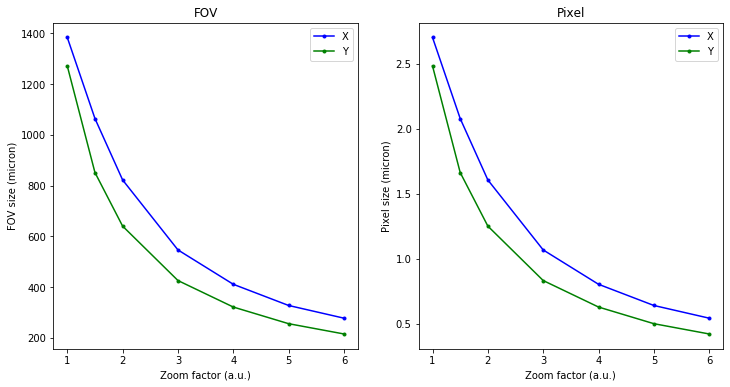

In [9]:
plt.figure(figsize=(12,6), facecolor='w', edgecolor='w')

ax1 = plt.subplot2grid( (1,2), (0,0) )
plt.plot(zoom,fov_x,'blue',marker=".",label="X")
plt.plot(zoom,fov_y,'green',marker=".",label="Y")
plt.xlabel("Zoom factor (a.u.)")
plt.ylabel("FOV size (micron)")
plt.title("FOV")
plt.legend()

ax2 = plt.subplot2grid( (1,2), (0,1) )
plt.plot(zoom,px_x,'blue',marker=".",label="X")
plt.plot(zoom,px_y,'green',marker=".",label="Y")
plt.xlabel("Zoom factor (a.u.)")
plt.ylabel("Pixel size (micron)")
plt.title("Pixel")
plt.legend()

plt.show()